# Data Collection & Cleaning


This notebook shows how data was collected and cleaned for this project

In [0]:
import pandas as pd
import sqlite3
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import urllib.request
import random

In [2]:
from google.colab import drive #Mounting Google drive so that data can be stored
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
## Reading from BAM Dataset sqlite file to get the urls of the images

df = pd.read_sql("select * from modules",
                 sqlite3.connect("/content/drive/My Drive/APS360_Style_Transfer/bam_tier_1.sqlite"),
                 index_col="mid")

## Reading to find the scores for relevant images

df1 = pd.read_sql("select * from scores",
                 sqlite3.connect("/content/drive/My Drive/APS360_Style_Transfer/bam_tier_1.sqlite"),
                 index_col="mid")

In [0]:
## Sorting the scores to find the most likely images with the required style traits

df1.sort_values(by=['media_watercolor'], inplace=True, ascending=False)
watercolour_url = df.loc[df1.index[:5000],'src']

df1.sort_values(by=['media_oilpaint'], inplace=True, ascending=False)
oilpaint_url = df.loc[df1.index[:5000],'src']

df1.sort_values(by=['media_pen_ink'], inplace=True, ascending=False)
pen_ink_url = df.loc[df1.index[:5000],'src']

df1.sort_values(by=['media_graphite'], inplace=True, ascending=False)
graphite_url = df.loc[df1.index[:5000],'src']

In [0]:
## Downloading the style images

def downloader(image_url, file_name):
    full_file_name ='/content/drive/My Drive/APS360_Style_Transfer/Style_images/media_graphite/' + str(file_name) + '.jpg'
    try:
      urllib.request.urlretrieve(image_url,full_file_name)
    except:
      return 1

i = 0
num_error = 0

for url in graphite_url.values:
    error = downloader(url, i)
    if error == 1:
      num_error += 1
    else:
      i += 1

In [0]:
def downloader(image_url, file_name):
    full_file_name ='/content/drive/My Drive/APS360_Style_Transfer/Style_images/media_pen_ink/' + str(file_name) + '.jpg'
    try:
      urllib.request.urlretrieve(image_url,full_file_name)
    except:
      return 1

i = 0
num_error = 0


for url in pen_ink_url.values[:1000]:
    error = downloader(url, i)
    if error == 1:
      num_error += 1
    else:
      i += 1

In [0]:
def downloader(image_url, file_name):
    full_file_name ='/content/drive/My Drive/APS360_Style_Transfer/Style_images/media_oilpaint/' + str(file_name) + '.jpg'
    try:
      urllib.request.urlretrieve(image_url,full_file_name)
    except:
      return 1

i = 0
num_error = 0


for url in oilpaint_url.values:
    error = downloader(url, i)
    if error == 1:
      num_error += 1
    elif i == 1000:
      break
    else:
      i += 1  

In [0]:
def downloader(image_url, file_name):
    full_file_name ='/content/drive/My Drive/APS360_Style_Transfer/Style_images/media_watercolor/' + str(file_name) + '.jpg'
    try:
      urllib.request.urlretrieve(image_url,full_file_name)
    except:
      return 1

i = 0
num_error = 0


for url in watercolour_url.values:
    error = downloader(url, i)
    if error == 1:
      num_error += 1
    elif i == 1000:
      break
    else:
      i += 1  

In [0]:
## Obtainning urls of content images

text_file = open('/content/drive/My Drive/APS360_Style_Transfer/fall11_urls.txt', encoding = "ISO-8859-1")
lines = text_file.readlines()
text_file.close()

In [0]:
## Downloading content images

def downloader(image_url, file_name):
    full_file_name ='/content/drive/My Drive/APS360_Style_Transfer/Content_images/' + str(file_name) + '.jpg'
    try:
      urllib.request.urlretrieve(image_url,full_file_name)
    except:
      return 1

i = 0
num_error = 0


for content in lines:
    url = content.split('\t')[1]
    error = downloader(url[:-1], i)
    if error == 1:
      num_error += 1
    elif i == 1000:
      break
    else:
      i += 1

In [0]:
## Sample code showing how image is loaded from the folder with required transformations

## To be run during training
transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.RandomCrop(256, pad_if_needed=True])
content_set = torchvision.datasets.ImageFolder(root = '/content/drive/My Drive/APS360_Style_Transfer/Curated_data/Content_images', transform = transform)

torch.Size([256, 256, 3])
0


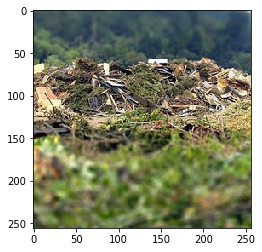

In [75]:
## Demonstrates that the image actually has the required (256*256) dimension

import matplotlib.pyplot as plt

image = content_set[0][0]
label = content_set[0][1]
img = np.transpose(image, [1,2,0])
print(img.shape)
plt.imshow(img)
print(label)


In [0]:
## Obtain relevant indices for training, validation and testing dataset

def get_relevant_indices(dataset):
    
    indices0 = []
    indices1 = []
    indices2 = []
    
    for i in range(len(dataset)):
        label_index = dataset[i][1] 
        # Appending the images that belong to each of the 3 datasets to 
        # different lists
        if label_index == 0:
          indices0.append(i)
        if label_index == 1:
          indices1.append(i)
        if label_index == 2:
          indices2.append(i)
          
    ## Grouping the indices of pictures that belong to each dataset
    train_indices = indices1
    val_indices = indices2 
    test_indices = indices0 
    
    return train_indices, val_indices, test_indices

In [0]:
train_indices, val_indices, test_indices = get_relevant_indices(content_set)

In [0]:
## Sample code for loading relevant the datasets for training, validation and testing
import random
np.random.seed(1000)

train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(content_set, batch_size=1,
                                               num_workers=1, sampler=train_sampler)
val_sampler = SubsetRandomSampler(val_indices)
val_loader = torch.utils.data.DataLoader(content_set, batch_size=1,
                                              num_workers=1, sampler=val_sampler)
test_sampler = SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(content_set, batch_size=1,
                                             num_workers=1, sampler=test_sampler)

In [86]:
for data in train_loader:
  print(data[0].shape)
  break

torch.Size([1, 3, 256, 256])
